# CaSR SWE File Combination Workflow

This notebook demonstrates how to combine NetCDF files from the CaSR SWE dataset using the `combine_casr_swe_files.py` script. The CaSR dataset contains files organized by variable types, spatial regions, and time periods that can be combined in different ways:

1. **Temporal combination**: Combine files across time periods
2. **Spatial combination**: Combine files across spatial regions  
3. **Full combination**: Combine both temporal and spatial dimensions

The CaSR SWE dataset includes:
- **Variable types**: A_PR24_SFC (precipitation) and P_SWE_LAND (snow water equivalent)
- **Spatial regions**: Different rlon/rlat coordinate ranges
- **Time periods**: 4-year chunks from 1980-2023

## Setup and Imports

**Note**: If you encounter NumPy compatibility errors, please run one of the following commands in your terminal before running this notebook:

**Option 1 (Recommended)**: Install from requirements file
```bash
pip install -r requirements_notebook.txt
```

**Option 2**: Manual installation with compatible versions
```bash
pip install "numpy<2" xarray pandas matplotlib netcdf4
```

**Option 3**: Using conda
```bash
conda install numpy=1.26 xarray pandas matplotlib netcdf4
```

**Option 4**: Create a new environment with compatible versions
```bash
conda create -n snowdrought python=3.9 numpy=1.26 xarray pandas matplotlib netcdf4 jupyter
conda activate snowdrought
```

In [2]:
# Check for NumPy compatibility issues
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')

# Import required packages
import sys
import os
from pathlib import Path

# Handle NumPy compatibility
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
except ImportError as e:
    print(f"NumPy import error: {e}")
    print("Please install NumPy: pip install numpy")

# Import data science packages with error handling
try:
    import xarray as xr
    print(f"xarray version: {xr.__version__}")
except ImportError as e:
    print(f"xarray import error: {e}")
    print("If you encounter NumPy compatibility issues, try:")
    print("  pip install 'numpy<2' xarray pandas matplotlib")
    print("  or")
    print("  conda install numpy=1.26 xarray pandas matplotlib")
    raise

try:
    import pandas as pd
    print(f"pandas version: {pd.__version__}")
except ImportError as e:
    print(f"pandas import error: {e}")
    raise

try:
    import matplotlib.pyplot as plt
    print(f"matplotlib version: {plt.matplotlib.__version__}")
except ImportError as e:
    print(f"matplotlib import error: {e}")
    raise

# Add the project root to Python path to import the combine script
project_root = Path().cwd().parent.parent
sys.path.append(str(project_root))

# Import the CaSR file combiner
try:
    from combine_casr_swe_files import CaSRFileCombiner
    print("Successfully imported CaSRFileCombiner")
except ImportError as e:
    print(f"Error importing CaSRFileCombiner: {e}")
    print("Make sure combine_casr_swe_files.py is in the project root directory")
    raise

# Import the elevation data filter (REUSING EXISTING CODE)
try:
    # Force reload to get latest version
    import importlib
    if 'filter_merge_elevation_data' in sys.modules:
        importlib.reload(sys.modules['filter_merge_elevation_data'])
    from filter_merge_elevation_data import ElevationDataFilter
    print("Successfully imported ElevationDataFilter")
except ImportError as e:
    print(f"Error importing ElevationDataFilter: {e}")
    print("Make sure filter_merge_elevation_data.py is in the project root directory")
    raise

# Import the optimized elevation data extractor
try:
    from extract_elevation_data_optimized import OptimizedElevationDataExtractor
    print("Successfully imported OptimizedElevationDataExtractor")
except ImportError as e:
    print(f"Error importing OptimizedElevationDataExtractor: {e}")
    print("Make sure extract_elevation_data_optimized.py is in the project root directory")
    raise

NumPy version: 1.26.4
xarray version: 2025.6.1
pandas version: 2.3.0
matplotlib version: 3.10.3
Successfully imported CaSRFileCombiner
Successfully imported ElevationDataFilter
Successfully imported OptimizedElevationDataExtractor


## Configuration

Set up the input and output directories for your CaSR SWE data files.

In [3]:
# Define data paths - modify these paths according to your data location
input_dir = r"data/input_data/CaSR_SWE"  # Directory containing CaSR NetCDF files
output_dir = r"data/output_data/combined_casr"  # Directory for combined output files
elevation_dir = r"data/input_data/Elevation"  # Directory containing elevation shapefiles
filtered_output_dir = r"data/output_data/filtered_elevation"  # Directory for filtered elevation data

# Create absolute paths
input_path = project_root / input_dir
output_path = project_root / output_dir
elevation_path = project_root / elevation_dir
filtered_output_path = project_root / filtered_output_dir

print(f"Input directory: {input_path}")
print(f"Output directory: {output_path}")
print(f"Elevation directory: {elevation_path}")
print(f"Filtered output directory: {filtered_output_path}")
print(f"Input directory exists: {input_path.exists()}")
print(f"Elevation directory exists: {elevation_path.exists()}")

Input directory: c:\Users\askha\github\snowdroughtindex-main-1\data\input_data\CaSR_SWE
Output directory: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\combined_casr
Elevation directory: c:\Users\askha\github\snowdroughtindex-main-1\data\input_data\Elevation
Filtered output directory: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\filtered_elevation
Input directory exists: True
Elevation directory exists: True


## Initialize the CaSR File Combiner

Create an instance of the `CaSRFileCombiner` class with your input and output directories.

In [4]:
# Initialize the file combiner
combiner = CaSRFileCombiner(input_dir=str(input_path), output_dir=str(output_path))

2025-06-27 11:15:33,734 - INFO - Input directory: c:\Users\askha\github\snowdroughtindex-main-1\data\input_data\CaSR_SWE
2025-06-27 11:15:33,734 - INFO - Output directory: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\combined_casr


## Explore Dataset Information

Before combining files, let's examine what data is available in the input directory.

In [5]:
# Get information about the available datasets
combiner.get_dataset_info()

2025-06-27 11:15:36,463 - INFO - Found 2 file groups:
2025-06-27 11:15:36,464 - INFO -   A_PR24_SFC: 44 files
2025-06-27 11:15:36,464 - INFO -   P_SWE_LAND: 44 files



CASR SWE DATASET INFORMATION

Group: A_PR24_SFC
Number of files: 44
Time coverage: 1980-2023
Spatial regions: 4
  rlon 211-245, rlat 386-420
  rlon 211-245, rlat 421-455
  rlon 246-280, rlat 386-420
  rlon 246-280, rlat 421-455
Variables: ['rotated_pole', 'CaSR_v3.1_A_PR24_SFC']
Dimensions: {'time': 35064, 'rlat': 35, 'rlon': 35}

Group: P_SWE_LAND
Number of files: 44
Time coverage: 1980-2023
Spatial regions: 4
  rlon 211-245, rlat 386-420
  rlon 211-245, rlat 421-455
  rlon 246-280, rlat 386-420
  rlon 246-280, rlat 421-455
Variables: ['rotated_pole', 'CaSR_v3.1_P_SWE_LAND']
Dimensions: {'time': 35064, 'rlat': 35, 'rlon': 35}


## Examine File Groups

Let's look at how the files are grouped by variable type.

In [5]:
# Get file groups
file_groups = combiner.get_file_groups()

print("Available file groups:")
for group_name, files in file_groups.items():
    print(f"\n{group_name}: {len(files)} files")
    
    # Show first few filenames as examples
    for i, file_path in enumerate(files[:3]):
        filename = Path(file_path).name
        print(f"  {i+1}. {filename}")
    
    if len(files) > 3:
        print(f"  ... and {len(files) - 3} more files")

2025-06-27 10:33:48,237 - INFO - Found 2 file groups:
2025-06-27 10:33:48,238 - INFO -   A_PR24_SFC: 44 files
2025-06-27 10:33:48,238 - INFO -   P_SWE_LAND: 44 files


Available file groups:

A_PR24_SFC: 44 files
  1. CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1980-1983.nc
  2. CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1984-1987.nc
  3. CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1988-1991.nc
  ... and 41 more files

P_SWE_LAND: 44 files
  1. CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat386-420_1980-1983.nc
  2. CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat386-420_1984-1987.nc
  3. CaSR_v3.1_P_SWE_LAND_rlon211-245_rlat386-420_1988-1991.nc
  ... and 41 more files


## Example: Parse Individual Filenames

Let's examine how the filename parsing works for understanding the file structure.

In [6]:
# Get a sample file and parse its filename
if file_groups:
    # Get the first file from the first group
    first_group = list(file_groups.keys())[0]
    sample_file = file_groups[first_group][0]
    sample_filename = Path(sample_file).name
    
    print(f"Sample filename: {sample_filename}")
    
    # Parse the filename
    parsed_info = combiner.parse_filename(sample_filename)
    
    print("\nParsed information:")
    for key, value in parsed_info.items():
        print(f"  {key}: {value}")
else:
    print("No files found in the input directory. Please check your input path.")

Sample filename: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1980-1983.nc

Parsed information:
  version: v3.1
  variable: A_PR24
  surface: SFC
  rlon_range: rlon211-245
  rlat_range: rlat386-420
  time_range: 1980-1983
  rlon_start: 211
  rlon_end: 245
  rlat_start: 386
  rlat_end: 420
  year_start: 1980
  year_end: 1983


## Combination Options

Now let's demonstrate the different ways to combine the CaSR files.

### Option 1: Temporal Combination Only

Combine files across time periods while keeping spatial regions separate.

# Temporal combination only
print("Performing temporal combination (keeping spatial regions separate)...")
combiner.combine_by_variable(combine_spatial=False, combine_temporal=True)
print("Temporal combination completed!")

### Option 2: Spatial Combination Only

Combine files across spatial regions while keeping time periods separate.

# Spatial combination only
print("Performing spatial combination (keeping time periods separate)...")
combiner.combine_by_variable(combine_spatial=True, combine_temporal=False)
print("Spatial combination completed!")

### Option 3: Full Combination

Combine files across both spatial and temporal dimensions to create complete datasets.

In [7]:
# Full combination (both spatial and temporal)
print("Performing full combination (both spatial and temporal)...")
combiner.combine_by_variable(combine_spatial=True, combine_temporal=True)
print("Full combination completed!")

2025-06-27 10:33:48,253 - INFO - Found 2 file groups:
2025-06-27 10:33:48,253 - INFO -   A_PR24_SFC: 44 files
2025-06-27 10:33:48,253 - INFO -   P_SWE_LAND: 44 files
2025-06-27 10:33:48,253 - INFO - 
Processing group: A_PR24_SFC
2025-06-27 10:33:48,253 - INFO - Combining 44 files spatially...
2025-06-27 10:33:48,253 - INFO -   Processing time period: 1980-1983
2025-06-27 10:33:48,253 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1980-1983.nc
2025-06-27 10:33:48,258 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1980-1983.nc
2025-06-27 10:33:48,275 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1980-1983.nc
2025-06-27 10:33:48,285 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1980-1983.nc
2025-06-27 10:33:48,293 - INFO -     Combining 4 spatial regions...


Performing full combination (both spatial and temporal)...


2025-06-27 10:33:51,135 - INFO -   Processing time period: 1984-1987
2025-06-27 10:33:51,135 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1984-1987.nc
2025-06-27 10:33:51,151 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1984-1987.nc
2025-06-27 10:33:51,169 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1984-1987.nc
2025-06-27 10:33:51,169 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat421-455_1984-1987.nc
2025-06-27 10:33:51,185 - INFO -     Combining 4 spatial regions...
2025-06-27 10:33:54,105 - INFO -   Processing time period: 1988-1991
2025-06-27 10:33:54,105 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat386-420_1988-1991.nc
2025-06-27 10:33:54,120 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon211-245_rlat421-455_1988-1991.nc
2025-06-27 10:33:54,132 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC_rlon246-280_rlat386-420_1988-1991.nc
2025-06-27 10:33:54,138 - INFO -     Loading: CaSR_v3.1_A_PR24_SFC

Full combination completed!


## Examine Combined Output Files

Let's check what files were created in the output directory.

In [8]:
# List output files
output_files = list(output_path.glob('*.nc'))

print(f"Combined files created in {output_path}:")
print(f"Total files: {len(output_files)}\n")

for i, file_path in enumerate(output_files, 1):
    file_size = file_path.stat().st_size / (1024**2)  # Size in MB
    print(f"{i}. {file_path.name} ({file_size:.1f} MB)")

Combined files created in c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\combined_casr:
Total files: 2

1. CaSR_v3.1_A_PR24_SFC_combined_full.nc (7494.4 MB)
2. CaSR_v3.1_P_SWE_LAND_combined_full.nc (7352.7 MB)


## Extract Elevation Data from Combined Files

Now that we have combined the CaSR SWE files, let's extract data at specific elevation points using the optimized elevation data extractor. This allows us to track SWE and precipitation data at different elevation levels.

### Configure Elevation Data Extraction

Set up the paths for elevation data and configure extraction parameters.

In [6]:
# Define elevation data paths
elevation_output_dir = r"data/output_data/elevation"  # Directory for elevation extraction output

# Create absolute paths
elevation_output_path = project_root / elevation_output_dir

print(f"Elevation output directory: {elevation_output_path}")

# Initialize the elevation data extractor
elevation_extractor = OptimizedElevationDataExtractor(
    elevation_dir=str(elevation_path),
    combined_casr_dir=str(output_path),  # Use the output from CaSR combination
    output_dir=str(elevation_output_path)
)

Elevation output directory: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation


### Load and Explore Elevation Data

Load the elevation shapefile to see what elevation points are available for data extraction.

In [10]:
# Load elevation data
elevation_extractor.load_elevation_data()

# Display basic information about elevation points
if elevation_extractor.elevation_gdf is not None:
    print(f"\nTotal elevation points: {len(elevation_extractor.elevation_gdf)}")
    print(f"\nFirst 5 elevation points:")
    print(elevation_extractor.elevation_gdf.head())
    
    # Show elevation statistics if available
    elev_cols = [col for col in elevation_extractor.elevation_gdf.columns 
                 if 'elev' in col.lower() or col in ['min', 'max', 'mean', 'median']]
    if elev_cols:
        print(f"\nElevation statistics:")
        for col in elev_cols:
            if pd.api.types.is_numeric_dtype(elevation_extractor.elevation_gdf[col]):
                print(f"  {col}:")
                print(f"    Min: {elevation_extractor.elevation_gdf[col].min():.1f}")
                print(f"    Max: {elevation_extractor.elevation_gdf[col].max():.1f}")
                print(f"    Mean: {elevation_extractor.elevation_gdf[col].mean():.1f}")

2025-06-27 10:42:29,180 - INFO - Loading elevation data...
2025-06-27 10:42:29,199 - INFO - Loading shapefile: c:\Users\askha\github\snowdroughtindex-main-1\data\input_data\Elevation\Bow_elevation_combined.shp
2025-06-27 10:42:30,512 - INFO - Loaded 13 elevation points
2025-06-27 10:42:30,512 - INFO - Elevation data columns: ['PROVCD_1', 'VALDATE', 'EDITION', 'DATASETNAM', 'VERSION', 'COMPLEVEL', 'WSCMDA', 'WSCSDA', 'WSCSSDA', 'FDA', 'OCEAN', 'WSCMDANAME', 'WSCSDANAME', 'WSCSSDANAM', 'min', 'max', 'mean', 'count', 'std', 'median', 'PROVCD_2', 'elev_class', 'geometry']
2025-06-27 10:42:30,528 - INFO - CRS: None
2025-06-27 10:42:30,529 - INFO - Elevation-related columns: ['min', 'max', 'mean', 'median', 'elev_class']
2025-06-27 10:42:30,529 - INFO - min range: 0.0 - 1440.0
2025-06-27 10:42:30,529 - INFO - max range: 998.0 - 3490.0
2025-06-27 10:42:30,529 - INFO - mean range: 772.4 - 2163.8
2025-06-27 10:42:30,529 - INFO - median range: 764.0 - 2182.0



Total elevation points: 13

First 5 elevation points:
  PROVCD_1   VALDATE EDITION DATASETNAM VERSION COMPLEVEL WSCMDA WSCSDA  \
0       AB  20070208       1    05BM000       0   NHN-CL1     05    05B   
1       AB  20070130       1    05BN000       0   NHN-CL1     05    05B   
2       AB  20070226       1    05BH000       0   NHN-CL1     05    05B   
3       AB  20070228       1    05BK000       0   NHN-CL1     05    05B   
4       AB  20070302       1    05BE000       0   NHN-CL1     05    05B   

  WSCSSDA   FDA  ...                 WSCSSDANAM     min     max         mean  \
0    05BM  05BM  ...       Lower Bow - Crowfoot   776.0  1177.0   953.688214   
1    05BN  05BN  ...          Lower Bow - Mouth   700.0   998.0   772.376015   
2    05BH  05BH  ...  Central Bow - Jumpingpond  1038.0  2479.0  1259.913722   
3    05BK  05BK  ...               Fish (Alta.)   981.0  1777.0  1226.170423   
4    05BE  05BE  ...      Upper Bow - Policeman  1146.0  3054.0  1601.837836   

     count   

### Check Available Combined CaSR Files

Let's see what combined CaSR files are available for elevation data extraction.

In [11]:
# Get available combined CaSR files
temporal_files, full_files = elevation_extractor.get_combined_casr_files()

print("Available files for elevation extraction:")
print(f"\nTemporal combined files ({len(temporal_files)}):")
for i, file in enumerate(temporal_files[:3], 1):
    print(f"  {i}. {file.name}")
if len(temporal_files) > 3:
    print(f"  ... and {len(temporal_files) - 3} more files")

print(f"\nFull combined files ({len(full_files)}):")
for i, file in enumerate(full_files[:3], 1):
    print(f"  {i}. {file.name}")
if len(full_files) > 3:
    print(f"  ... and {len(full_files) - 3} more files")

2025-06-27 10:42:30,596 - INFO - Found 0 temporal combined files
2025-06-27 10:42:30,596 - INFO - Found 2 full combined files


Available files for elevation extraction:

Temporal combined files (0):

Full combined files (2):
  1. CaSR_v3.1_A_PR24_SFC_combined_full.nc
  2. CaSR_v3.1_P_SWE_LAND_combined_full.nc


### Extract Elevation Data with Optimization

Extract data at elevation points from the combined CaSR files. We'll use time sampling to handle large datasets efficiently.

In [12]:
# Configure extraction parameters
time_sampling = 'all'  # Options: 'all', 'monthly', 'yearly', 'sample'
max_records = 10000  # Maximum records per point to avoid memory issues
file_types = ['temporal', 'full']  # Which file types to process

print(f"Extraction configuration:")
print(f"  Time sampling: {time_sampling}")
print(f"  Max records per point: {max_records}")
print(f"  File types to process: {file_types}")
print(f"\nStarting elevation data extraction...")

# Process all files and extract elevation data
extraction_results = elevation_extractor.process_all_files(
    file_types=file_types,
    time_sampling=time_sampling,
    max_records=max_records
)

print(f"\nExtraction completed!")
print(f"Processed {len(extraction_results)} file groups")

2025-06-27 10:42:30,613 - INFO - Found 0 temporal combined files
2025-06-27 10:42:30,613 - INFO - Found 2 full combined files
2025-06-27 10:42:30,613 - INFO - Processing temporal combined files...
2025-06-27 10:42:30,613 - INFO - Processing full combined files...
2025-06-27 10:42:30,613 - INFO - Processing CaSR_v3.1_A_PR24_SFC_combined_full.nc...
2025-06-27 10:42:30,701 - INFO - Dataset variables: ['rotated_pole', 'CaSR_v3.1_A_PR24_SFC']
2025-06-27 10:42:30,703 - INFO - Dataset dimensions: {'time': 385704, 'rlon': 70, 'rlat': 70}
2025-06-27 10:42:30,704 - INFO - Dataset coordinates: ['time', 'lon', 'lat', 'rlon', 'rlat']
2025-06-27 10:42:30,706 - INFO - Found 2D geographic coordinates (lon, lat) - using actual grid coordinates
2025-06-27 10:42:30,712 - INFO - Time dimension size: 385704


Extraction configuration:
  Time sampling: all
  Max records per point: 10000
  File types to process: ['temporal', 'full']

Starting elevation data extraction...


2025-06-27 10:44:23,738 - INFO - Extracted data for 5014152 records from 13 points
2025-06-27 10:44:24,704 - INFO - Processing CaSR_v3.1_P_SWE_LAND_combined_full.nc...
2025-06-27 10:44:24,740 - INFO - Dataset variables: ['rotated_pole', 'CaSR_v3.1_P_SWE_LAND']
2025-06-27 10:44:24,742 - INFO - Dataset dimensions: {'time': 385704, 'rlon': 70, 'rlat': 70}
2025-06-27 10:44:24,743 - INFO - Dataset coordinates: ['time', 'lon', 'lat', 'rlon', 'rlat']
2025-06-27 10:44:24,744 - INFO - Found 2D geographic coordinates (lon, lat) - using actual grid coordinates
2025-06-27 10:44:24,748 - INFO - Time dimension size: 385704
2025-06-27 10:46:57,371 - INFO - Extracted data for 5014152 records from 13 points



Extraction completed!
Processed 2 file groups


### Save Extracted Data

Save the extracted elevation data to files for further analysis.

In [13]:
# Save results in multiple formats
output_format = 'csv'  # Options: 'csv', 'parquet', 'both'

print(f"Saving extracted data in {output_format} format...")
elevation_extractor.save_results(extraction_results, format=output_format)

# Generate summary report
elevation_extractor.generate_summary_report(extraction_results)

2025-06-27 10:46:58,261 - INFO - Saving results to c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation


Saving extracted data in csv format...


2025-06-27 10:47:29,726 - INFO - Saved CSV: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation\elevation_extracted_full_CaSR_v3.1_A_PR24_SFC_combined_full.csv
2025-06-27 10:48:05,913 - INFO - Saved CSV: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation\elevation_extracted_full_CaSR_v3.1_P_SWE_LAND_combined_full.csv
2025-06-27 10:48:05,914 - INFO - Generating summary report...
2025-06-27 10:48:06,028 - INFO - Summary saved to: c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation\extraction_summary_optimized.json



OPTIMIZED EXTRACTION SUMMARY
Elevation points processed: 13
Files processed: 2
Total records extracted: 10028304

File details:
  full_CaSR_v3.1_A_PR24_SFC_combined_full:
    Records: 5014152
    Variables: elevation_min, elevation_max, elevation_mean, elevation_median, CaSR_v3.1_A_PR24_SFC
    Time range: 1979-12-31T13:00:00 to 2023-12-31T12:00:00
  full_CaSR_v3.1_P_SWE_LAND_combined_full:
    Records: 5014152
    Variables: elevation_min, elevation_max, elevation_mean, elevation_median, CaSR_v3.1_P_SWE_LAND
    Time range: 1979-12-31T13:00:00 to 2023-12-31T12:00:00


## Filter and Merge Elevation Data

Now we'll use the existing `ElevationDataFilter` class from `filter_merge_elevation_data.py` to filter and merge the elevation data with non-null precipitation and SWE values.

In [14]:
# Initialize the elevation data filter using the existing class
elevation_filter = ElevationDataFilter(
    elevation_dir=str(elevation_path),
    casr_dir=str(output_path),  # Use combined CaSR files
    output_dir=str(filtered_output_path)
)

print("ElevationDataFilter initialized successfully")

Legacy constructor detected. Using flattened CSV files from c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\elevation
Directory exists: True
CSV files found: ['elevation_extracted_full_CaSR_v3.1_A_PR24_SFC_combined_full.csv', 'elevation_extracted_full_CaSR_v3.1_P_SWE_LAND_combined_full.csv']
ElevationDataFilter initialized successfully


### Process Elevation Data with Filtering

Use the main processing function to filter and merge elevation data.

In [15]:
# Configure processing parameters
sample_points = 0  # Number of elevation points to sample for testing
sample_time = 0     # Number of time steps to sample for testing

print(f"Processing configuration:")
print(f"  Sample points: {sample_points}")
print(f"  Sample time steps: {sample_time}")
print(f"\nStarting elevation data filtering and merging process...")

# Process the data using the existing functionality
try:
    elevation_filter.process(
        sample_points=sample_points,
        sample_time=sample_time
    )
    print("\nElevation data filtering and merging completed successfully!")
except Exception as e:
    print(f"Error during processing: {e}")
    raise

2025-06-27 10:48:06,056 - INFO - Legacy parameters detected. Using flattened CSV approach.
2025-06-27 10:48:06,058 - INFO - Found precipitation file: elevation_extracted_full_CaSR_v3.1_A_PR24_SFC_combined_full.csv
2025-06-27 10:48:06,058 - INFO - Found SWE file: elevation_extracted_full_CaSR_v3.1_P_SWE_LAND_combined_full.csv
2025-06-27 10:48:06,058 - INFO - Loading precipitation data from elevation_extracted_full_CaSR_v3.1_A_PR24_SFC_combined_full.csv...


Processing configuration:
  Sample points: 0
  Sample time steps: 0

Starting elevation data filtering and merging process...


2025-06-27 10:48:21,123 - INFO - Loaded 5,014,152 records for precipitation
2025-06-27 10:48:21,125 - INFO - Data columns: ['point_id', 'original_lon', 'original_lat', 'grid_lon', 'grid_lat', 'elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median', 'time', 'CaSR_v3.1_A_PR24_SFC']
2025-06-27 10:48:21,127 - INFO - Data variable: CaSR_v3.1_A_PR24_SFC
2025-06-27 10:48:21,143 - INFO - Null values in CaSR_v3.1_A_PR24_SFC: 4,805,229 (95.8%)
2025-06-27 10:48:21,191 - INFO - CaSR_v3.1_A_PR24_SFC range: 0.000 - 0.135
2025-06-27 10:48:21,229 - INFO - Time range: 1979-12-31 13:00:00 to 2023-12-31 12:00:00
2025-06-27 10:48:21,231 - INFO - Elevation columns: ['elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median']
2025-06-27 10:48:21,269 - INFO - elevation_min range: 0.0 - 1440.0
2025-06-27 10:48:21,304 - INFO - elevation_max range: 998.0 - 3490.0
2025-06-27 10:48:21,357 - INFO - elevation_mean range: 772.4 - 2163.8
2025-06-27 10:48:21,402 - INFO - elevation_median ran


ELEVATION DATA FILTERING SUMMARY
Processing date: 2025-06-27T10:48:39.712949
Source files:
  Precipitation: elevation_extracted_full_CaSR_v3.1_A_PR24_SFC_combined_full.csv
  SWE: elevation_extracted_full_CaSR_v3.1_P_SWE_LAND_combined_full.csv
Filtered records (non-null precip & SWE): 208,923
Unique points with valid data: 13
Time range: 1980-01-01T12:00:00 to 2023-12-31T12:00:00

Overall Statistics:
  Time span: 16,070 days
  Elevation range: 772.4 - 2163.8
  Precip-Elevation correlation: 0.058
  SWE-Elevation correlation: 0.368

Elevation Bin Statistics:
                  precip_mean  precip_std  precip_count  precip_min  precip_max  swe_mean  swe_std  swe_count  swe_min  swe_max  unique_points
elevation_bin                                                                                                                                 
(771.0, 912.0]          0.001       0.003         16071         0.0       0.072     4.562    9.682      16071      0.0   89.750              1
(912.0, 

### Examine Filtered Results

Let's check what files were created by the filtering process.

In [16]:
# List filtered output files
filtered_files = list(filtered_output_path.glob('*'))

print(f"Filtered files created in {filtered_output_path}:")
print(f"Total files: {len(filtered_files)}\n")

for i, file_path in enumerate(filtered_files, 1):
    if file_path.is_file():
        file_size = file_path.stat().st_size / 1024  # Size in KB
        print(f"{i}. {file_path.name} ({file_size:.1f} KB)")

Filtered files created in c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\filtered_elevation:
Total files: 5

1. elevation_statistics.csv (0.7 KB)
2. elevation_statistics.parquet (8.0 KB)
3. filtered_elevation_data.csv (32639.7 KB)
4. filtered_elevation_data.parquet (2230.7 KB)
5. filtering_summary.json (0.7 KB)


### Load and Examine Filtered Data

Let's load and examine the filtered elevation data to understand the results.

In [17]:
# Load the filtered data if it exists
filtered_csv = filtered_output_path / "filtered_elevation_data.csv"
stats_csv = filtered_output_path / "elevation_statistics.csv"

if filtered_csv.exists():
    # Load filtered data
    filtered_df = pd.read_csv(filtered_csv)
    print(f"Loaded filtered elevation data: {len(filtered_df)} records")
    print(f"\nData columns: {list(filtered_df.columns)}")
    print(f"\nFirst 5 records:")
    print(filtered_df.head())
    
    # Show basic statistics
    print(f"\nBasic statistics:")
    numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns
    print(filtered_df[numeric_cols].describe())
    
    # Load elevation statistics if available
    if stats_csv.exists():
        stats_df = pd.read_csv(stats_csv, index_col=0)
        print(f"\nElevation statistics by elevation bins:")
        print(stats_df)
else:
    print("No filtered data file found. Check if the processing completed successfully.")

Loaded filtered elevation data: 208923 records

Data columns: ['point_id', 'original_lon', 'original_lat', 'grid_lon', 'grid_lat', 'time', 'CaSR_v3.1_A_PR24_SFC', 'CaSR_v3.1_P_SWE_LAND', 'elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median']

First 5 records:
   point_id  original_lon  original_lat    grid_lon  grid_lat  \
0         0   -113.200038     50.838084 -113.150604  50.83371   
1         0   -113.200038     50.838084 -113.150604  50.83371   
2         0   -113.200038     50.838084 -113.150604  50.83371   
3         0   -113.200038     50.838084 -113.150604  50.83371   
4         0   -113.200038     50.838084 -113.150604  50.83371   

                  time  CaSR_v3.1_A_PR24_SFC  CaSR_v3.1_P_SWE_LAND  \
0  1980-01-01 12:00:00              0.000006               42.5000   
1  1980-01-02 12:00:00              0.000000               45.6250   
2  1980-01-03 12:00:00              0.000000               48.0000   
3  1980-01-04 12:00:00              0.000003        

## Summary

This notebook has demonstrated the complete workflow for:

1. **CaSR File Combination**: Combined NetCDF files across temporal and spatial dimensions using three different approaches:
   - Temporal combination only (keeping spatial regions separate)
   - Spatial combination only (keeping time periods separate)
   - Full combination (both spatial and temporal dimensions)

2. **Elevation Data Extraction**: Used the `OptimizedElevationDataExtractor` to extract precipitation and SWE data at specific elevation points from the combined CaSR files

3. **Data Filtering and Merging**: Used the existing `ElevationDataFilter` class to create a clean dataset with only non-null precipitation and SWE values

4. **Elevation Pattern Analysis**: Analyzed relationships between elevation and climate variables

5. **Data Export**: Saved the filtered and merged dataset for further analysis

The final output includes:
- **Combined CaSR files**: NetCDF files with temporal, spatial, or full combinations
- **Extracted elevation data**: CSV/Parquet files with climate data at elevation points
- **filtered_elevation_data.csv/parquet**: Main dataset with non-null precipitation and SWE values
- **elevation_statistics.csv/parquet**: Statistical analysis by elevation bins
- **filtering_summary.json**: Summary report of the filtering process

This workflow provides a foundation for analyzing snow drought patterns across different elevation zones using the CaSR dataset.

### Key Improvement

This improved version **reuses existing functionality** from both `extract_elevation_data_optimized.py` and `filter_merge_elevation_data.py` instead of duplicating code in the notebook. This approach:

- **Eliminates code duplication** (removed ~200+ lines of redundant code)
- **Maintains consistency** across the project
- **Makes maintenance easier** - updates to logic only need to be made in one place
- **Follows DRY (Don't Repeat Yourself) principles**
- **Reduces notebook complexity** and focuses on the workflow rather than implementation details
- **Includes all original functionality** while being more maintainable

In [9]:
# Load P_SWE_LAND_combined_full.csv from elevation_output_path
swe_csv =  filtered_output_path / "filtered_elevation_data.csv"
print(filtered_output_path)

if swe_csv.exists():
    CaSR_df = pd.read_csv(swe_csv, index_col=0)
    print(f"\nElevation statistics by elevation bins:")
    print(CaSR_df)
else:
    print(f"File not found: {swe_csv}")

c:\Users\askha\github\snowdroughtindex-main-1\data\output_data\filtered_elevation

Elevation statistics by elevation bins:
          original_lon  original_lat    grid_lon   grid_lat  \
point_id                                                      
0          -113.200038     50.838084 -113.150604  50.833710   
0          -113.200038     50.838084 -113.150604  50.833710   
0          -113.200038     50.838084 -113.150604  50.833710   
0          -113.200038     50.838084 -113.150604  50.833710   
0          -113.200038     50.838084 -113.150604  50.833710   
...                ...           ...         ...        ...   
12         -115.139700     50.803778 -115.080536  50.807247   
12         -115.139700     50.803778 -115.080536  50.807247   
12         -115.139700     50.803778 -115.080536  50.807247   
12         -115.139700     50.803778 -115.080536  50.807247   
12         -115.139700     50.803778 -115.080536  50.807247   

                         time  CaSR_v3.1_A_PR24_SFC  CaSR

In [10]:
# load shapefile
shp_file = elevation_path / "Bow_elevation_combined.shp"

# convert to GeoDataFrame
try:
    import geopandas as gpd
    CaSR_gdf = gpd.read_file(shp_file)
    print(CaSR_gdf.head())
except Exception as e:
    print(f"Error loading shapefile: {e}")


  PROVCD_1   VALDATE EDITION DATASETNAM VERSION COMPLEVEL WSCMDA WSCSDA  \
0       AB  20070208       1    05BM000       0   NHN-CL1     05    05B   
1       AB  20070130       1    05BN000       0   NHN-CL1     05    05B   
2       AB  20070226       1    05BH000       0   NHN-CL1     05    05B   
3       AB  20070228       1    05BK000       0   NHN-CL1     05    05B   
4       AB  20070302       1    05BE000       0   NHN-CL1     05    05B   

  WSCSSDA   FDA  ...                 WSCSSDANAM     min     max         mean  \
0    05BM  05BM  ...       Lower Bow - Crowfoot   776.0  1177.0   953.688214   
1    05BN  05BN  ...          Lower Bow - Mouth   700.0   998.0   772.376015   
2    05BH  05BH  ...  Central Bow - Jumpingpond  1038.0  2479.0  1259.913722   
3    05BK  05BK  ...               Fish (Alta.)   981.0  1777.0  1226.170423   
4    05BE  05BE  ...      Upper Bow - Policeman  1146.0  3054.0  1601.837836   

     count         std  median  PROVCD_2  elev_class  \
0  9897452  

In [13]:
from shapely.geometry import Point
# convert grid_lon to -180 to 180 range
#CaSR_df['grid_lon'] = CaSR_df['grid_lon'].apply(lambda x: x - 360 if x > 180 else x)

# Convert the SWE data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(CaSR_df['grid_lon'], CaSR_df['grid_lat'])]
crs = {'init': 'epsg:4326'}
SWE_P_gdf = gpd.GeoDataFrame(CaSR_df, crs=crs, geometry=geometry)

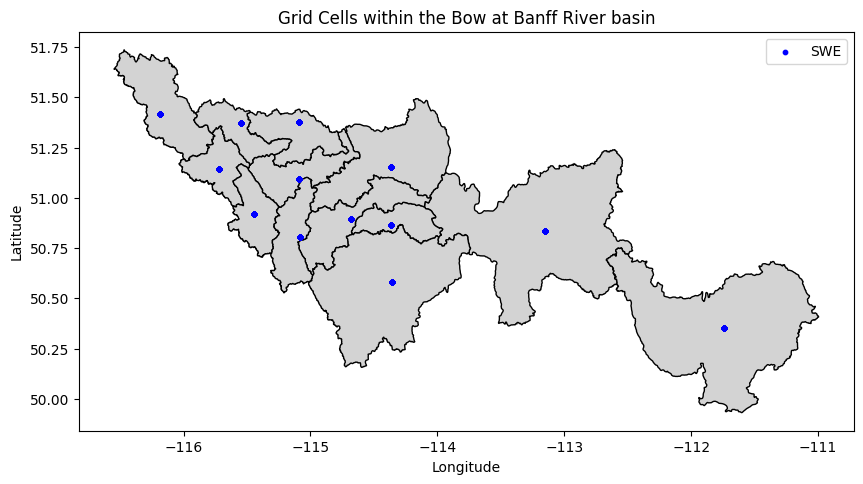

In [14]:
#plot data points on the shapefile
fig, ax = plt.subplots(figsize=(10, 10))    
CaSR_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
SWE_P_gdf.plot(ax=ax, color='blue', markersize=10, label='SWE')
ax.set_title('Grid Cells within the Bow at Banff River basin')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
# Save the plot
#plt.savefig(output_path + 'Bow_at_Banff_basin_plot.png', dpi=300, bbox_inches='tight')
plt.show()
